## Sentimental Analysis
----

- **many to one**
    - 영화 리뷰 텍스트(many)를 입력으로 받아 긍정 또는 부정(one)을 출력하는 구조
    - **Embedding**: 영화 리뷰(text)를 벡터로 변환하는 연산
    - **LSTM**: 시계열 데이터를 처리하기 위한 구조
    - **Linear**: 결과 출력

## `Step 1` : Load libraries & Datsets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter

In [2]:
data = pd.read_csv('exercise4.csv')
data.head()

,processed,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production . The filming te...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1


In [3]:
data['processed'][0]

'One reviewer mentioned watching Oz episode hooked . They right , exactly happened . The first thing struck Oz brutality unflinching scene violence , set right word GO . Trust , show faint hearted timid . This show pull punch regard drug , sex violence . Its hardcore , classic use word . It called OZ nickname given Oswald Maximum Security State Penitentary . It focus mainly Emerald City , experimental section prison cell glass front face inwards , privacy high agenda . Em City home many . . Aryans , Muslims , gangsta , Latinos , Christians , Italians , Irish . . . . scuffle , death stare , dodgy dealing shady agreement never far away . I would say main appeal show due fact go show dare . Forget pretty picture painted mainstream audience , forget charm , forget romance . . . OZ mess around . The first episode I ever saw struck nasty surreal , I say I ready , I watched , I developed taste Oz , got accustomed high level graphic violence . Not violence , injustice crooked guard sold nickel

In [4]:
data['processed'] = data['processed'].str.lower().replace(r"[^a-zA-Z ]", "", regex=True)

In [5]:
data['processed'][0]

'one reviewer mentioned watching oz episode hooked  they right  exactly happened  the first thing struck oz brutality unflinching scene violence  set right word go  trust  show faint hearted timid  this show pull punch regard drug  sex violence  its hardcore  classic use word  it called oz nickname given oswald maximum security state penitentary  it focus mainly emerald city  experimental section prison cell glass front face inwards  privacy high agenda  em city home many   aryans  muslims  gangsta  latinos  christians  italians  irish     scuffle  death stare  dodgy dealing shady agreement never far away  i would say main appeal show due fact go show dare  forget pretty picture painted mainstream audience  forget charm  forget romance    oz mess around  the first episode i ever saw struck nasty surreal  i say i ready  i watched  i developed taste oz  got accustomed high level graphic violence  not violence  injustice crooked guard sold nickel  inmate kill order get away  well mannered

###  - 사전생성

 * 리뷰 문장에 들어있는 단어들을 추출하고, 각각의 단어에 숫자를 부여하는 작업
 * ['one', 'reviewer', 'mentioned', 'watching', 'oz', 'episode', 'hooked']

In [7]:
# 문장에 포함된 단어 토큰화
reviews = data['processed'].values
words = ' '.join(reviews).split()
words[:10]

['one',
 'reviewer',
 'mentioned',
 'watching',
 'oz',
 'episode',
 'hooked',
 'they',
 'right',
 'exactly']

In [63]:
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}
#word2int

In [26]:
word2int['<PAD>']

0

### - 리뷰 인코딩
 * 리뷰에 포함된 단어를 숫자형태로 변환하는 작업
 * {'i': 1, 'movie': 2, 'film': 3, 'the': 4, 'one': 5, 'like': 6, 'it': 7, 'time': 8, 'this': 9, 'good': 10, 'character': 11,...}

In [9]:
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:02<00:00, 24930.36it/s]


In [10]:
reviews_enc[0][1:10]

[1095, 972, 74, 2893, 186, 2982, 119, 114, 538]

In [11]:
data['processed'][0]

'one reviewer mentioned watching oz episode hooked  they right  exactly happened  the first thing struck oz brutality unflinching scene violence  set right word go  trust  show faint hearted timid  this show pull punch regard drug  sex violence  its hardcore  classic use word  it called oz nickname given oswald maximum security state penitentary  it focus mainly emerald city  experimental section prison cell glass front face inwards  privacy high agenda  em city home many   aryans  muslims  gangsta  latinos  christians  italians  irish     scuffle  death stare  dodgy dealing shady agreement never far away  i would say main appeal show due fact go show dare  forget pretty picture painted mainstream audience  forget charm  forget romance    oz mess around  the first episode i ever saw struck nasty surreal  i say i ready  i watched  i developed taste oz  got accustomed high level graphic violence  not violence  injustice crooked guard sold nickel  inmate kill order get away  well mannered

In [12]:
word2int['one'], word2int['reviewer'], word2int['mentioned']

(5, 1095, 972)

In [13]:
data['encoded'] = reviews_enc
data['encoded']

0        [5, 1095, 972, 74, 2893, 186, 2982, 119, 114, ...
1        [45, 311, 53, 247, 4, 1270, 1633, 16086, 78, 8...
2        [1, 97, 311, 28, 1053, 8, 763, 1343, 2345, 112...
3        [591, 130, 53, 221, 3123, 33, 565, 3653, 608, ...
4        [57645, 9676, 39, 8, 203, 1993, 1312, 3, 37, 3...
                               ...                        
49995    [1, 97, 2, 114, 10, 191, 7, 1413, 128, 26, 913...
49996    [22, 40, 22, 307, 22, 50, 2847, 869, 545, 1364...
49997    [1, 3168, 4064, 34678, 7571, 269, 4234, 4064, ...
49998    [1, 86, 2839, 825, 369, 348, 9292, 5, 9, 208, ...
49999    [264, 5, 5445, 109, 1941, 2, 213, 328, 123, 44...
Name: encoded, Length: 50000, dtype: object

### - 길이 맞춰주기(padding or trim)
 * 신경망의 입력으로 사용하기 위해 일정 길이만큼 맞춰주는 작업
 * 길이가 긴 문장은 잘라주고(trim), 길이가 짧은 문장은 채워주는(padding) 작업

In [49]:
def pad_features(reviews, pad_id, seq_length=128):
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

In [64]:
np.full((5,3),2)

array([[2, 2, 2],
       [2, 2, 2],
       [2, 2, 2],
       [2, 2, 2],
       [2, 2, 2]])

In [50]:
word2int['<PAD>']

0

In [51]:
labels = data['label'].to_numpy()
labels

array([1, 1, 1, ..., 0, 0, 0])

### - 데이터 분할

In [52]:
# train test split
train_size = .8
split_id = int(len(features) * train_size)
train_x, test_x, train_y, test_y = features[:split_id], features[split_id:], labels[:split_id], labels[split_id:]

split_id = int(len(train_x) * train_size)
train_x, valid_x, train_y, valid_y = train_x[:split_id], train_x[split_id:], train_y[:split_id], train_y[split_id:]

print('Train X shape: {}, Valid X shape: {}, Test X shape: {}'.format(train_x.shape, valid_x.shape, test_x.shape))
print('Train y shape: {}, Valid y shape: {}, Test y shape: {}'.format(train_y.shape, valid_y.shape, test_y.shape))

Train X shape: (32000, 256), Valid X shape: (8000, 256), Test X shape: (10000, 256)
Train y shape: (32000,), Valid y shape: (8000,), Test y shape: (10000,)


## `Step 2` : Create DataLoader 

In [53]:
# set hyperparameter
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

lr = 0.001
batch_size = 128
vocab_size = len(word2int)
embedding_size = 256
dropout = 0.25

epochs = 8
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'epochs': epochs
}

es_limit = 5

cuda


In [54]:
trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

## `Step 3` : Set Network Structure

In [55]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_size=400):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, 512, 2, dropout=0.25, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.long()
        x = self.embedding(x)
        o, _ = self.lstm(x)
        o = o[:, -1, :]
        o = self.dropout(o)
        o = self.fc(o)
        o = self.sigmoid(o)

        return o

## `Step 4` : Create Model instance 

In [56]:
model = LSTMClassifier(vocab_size, embedding_size).to(device)
print(model)

LSTMClassifier(
  (embedding): Embedding(96140, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.25)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## `Step 5` : Model compile 

In [57]:
criterion = nn.BCELoss()
optim = Adam(model.parameters(), lr=lr)

## `Step 6` : Set train loop

In [58]:
def train(model, trainloader):
    model.train()

    train_loss = 0
    train_acc = 0

    for id, (X, y) in enumerate(trainloader):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred.squeeze(), y.float())
        loss.backward()
        optim.step()

        train_loss += loss.item()
        y_pred = torch.tensor([1 if i == True else 0 for i in y_pred > 0.5], device=device)
        equals = y_pred == y
        acc = torch.mean(equals.type(torch.FloatTensor))
        train_acc += acc.item()

    history['train_loss'].append(train_loss / len(trainloader))
    history['train_acc'].append(train_acc / len(trainloader))

    return train_loss, train_acc

## `Step 7` : Set test loop

In [59]:
def validation(model, valloader):
    model.eval()

    val_loss = 0
    val_acc = 0

    with torch.no_grad():
        for id, (X,y) in enumerate(valloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = criterion(y_pred.squeeze(), y.float())

            val_loss += loss.item()

            y_pred = torch.tensor([1 if i == True else 0 for i in y_pred > 0.5], device=device)
            equals = y_pred == y
            acc = torch.mean(equals.type(torch.FloatTensor))
            val_acc += acc.item()

        history['val_loss'].append(val_loss / len(valloader))
        history['val_acc'].append(val_acc / len(valloader))

    return val_loss, val_acc

    
    

## `Step 8` : Run Model 

In [60]:
# train loop
epochloop = tqdm(range(epochs), desc='Training')

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

for e in epochloop:
    train_loss, train_acc = train(model, trainloader)
    val_loss, val_acc = validation(model, valloader)
    epochloop.write(f'Epoch[{e+1}/{epochs}] Train Loss: {train_loss / len(trainloader):.3f}, Train Acc: {train_acc / len(trainloader):.3f}, Val Loss: {val_loss / len(valloader):.3f}, Val Acc: {val_acc / len(valloader):.3f}')

    # save model if validation loss decrease
    if val_loss / len(valloader) <= val_loss_min:
        torch.save(model.state_dict(), './sentiment_lstm.pt')
        val_loss_min=val_loss / len(valloader)
        es_trigger = 0

    else:
        es_trigger += 1

    # early stop
    if es_trigger >= es_limit:
        epochloop.write(f'Early stopped at Epoch-{e+1}')
        history['epochs'] = e+1
        break

Training:   0%|                                                                                   | 0/8 [00:12<?, ?it/s]

Epoch[1/8] Train Loss: 0.694, Train Acc: 0.506, Val Loss: 0.692, Val Acc: 0.496


Training:  25%|██████████████████▊                                                        | 2/8 [00:23<01:10, 11.75s/it]

Epoch[2/8] Train Loss: 0.694, Train Acc: 0.506, Val Loss: 0.692, Val Acc: 0.514


Training:  25%|██████████████████▊                                                        | 2/8 [00:32<01:10, 11.75s/it]

Epoch[3/8] Train Loss: 0.669, Train Acc: 0.570, Val Loss: 0.650, Val Acc: 0.706


Training:  38%|████████████████████████████▏                                              | 3/8 [00:42<00:53, 10.67s/it]

Epoch[4/8] Train Loss: 0.478, Train Acc: 0.800, Val Loss: 0.601, Val Acc: 0.772


Training:  50%|█████████████████████████████████████▌                                     | 4/8 [00:51<00:40, 10.24s/it]

Epoch[5/8] Train Loss: 0.448, Train Acc: 0.811, Val Loss: 0.405, Val Acc: 0.818


Training:  62%|██████████████████████████████████████████████▉                            | 5/8 [01:01<00:29,  9.82s/it]

Epoch[6/8] Train Loss: 0.314, Train Acc: 0.879, Val Loss: 0.357, Val Acc: 0.847


Training:  88%|█████████████████████████████████████████████████████████████████▋         | 7/8 [01:11<00:09,  9.95s/it]

Epoch[7/8] Train Loss: 0.237, Train Acc: 0.914, Val Loss: 0.384, Val Acc: 0.842


Training: 100%|███████████████████████████████████████████████████████████████████████████| 8/8 [01:21<00:00, 10.20s/it]

Epoch[8/8] Train Loss: 0.203, Train Acc: 0.932, Val Loss: 0.426, Val Acc: 0.856


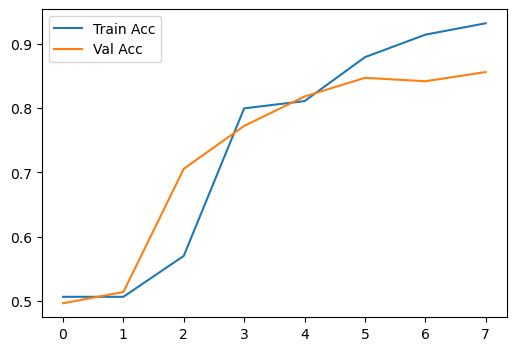

In [61]:
# plot loss
plt.figure(figsize=(6,4))
plt.plot(range(history['epochs']), history['train_acc'][:history['epochs']], label='Train Acc')
plt.plot(range(history['epochs']), history['val_acc'][:history['epochs']], label='Val Acc')
plt.legend()
plt.show()

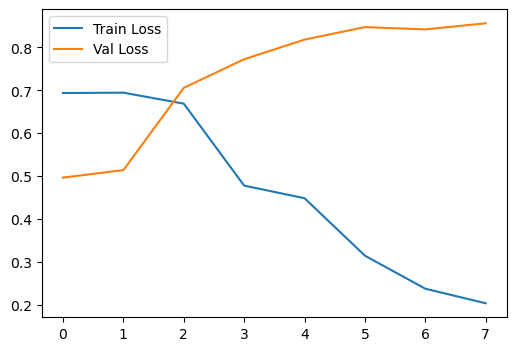

In [62]:
# plot loss
plt.figure(figsize=(6,4))
plt.plot(range(history['epochs']), history['train_loss'][:history['epochs']], label='Train Loss')
plt.plot(range(history['epochs']), history['val_acc'][:history['epochs']], label='Val Loss')
plt.legend()
plt.show()